In [65]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import torch
from torchquad import set_up_backend
from torchquad import Trapezoid, Simpson, MonteCarlo
from torch import exp, sqrt, sin, cos

In [2]:
set_up_backend("torch", data_type="float32")

c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


## Konstante i osnovne funkcije

In [3]:
kb = 8.6173303 * 10**(-5)
hbar = 6.582119569*10**(-16)
pi = np.pi

hbar_w_op = torch.Tensor([0.2]).to("cuda")
hbar_w_ac = 0.03
G_op2 = 0.25
G_ac2 = 0.05
eta_0 = 5 * 10**(-3) # min=0.3 meV
M = 0.05
Kf = 0.25 # eV
vf = 6 * 10**5
a = 154**(1/3) * 10**(-10)
T_0 = 50

Ef = sqrt(torch.FloatTensor([Kf**2 + M**2])).to("cuda")
Kf_ = Kf / hbar / vf * a # unitless

In [4]:
def fermi_dirac(E, Ef, T): 
    if T > 0:
        return torch.where(E > Ef, exp((-E + Ef) / (kb * T)) / (exp((-E + Ef) / (kb * T)) + 1), 1 / (exp((E - Ef) / (kb * T)) + 1))
    else:
        return torch.where(E < Ef, 0, 1) 

def bose_einstein(E,T): 
    assert T > 0
    return exp(-E / (kb * T)) / (-exp(-E / (kb * T)) + 1)

def chemical_potential(T):
    return Ef - pi**2 / 6 * (2 * Ef**2 - M**2) / Ef / (Ef**2 - M**2) * (kb * T)**2 - 7 / 360 * pi**4 * 3 * M**4 / Ef / (Ef**2 - M**2)**3 * (kb * T)**4

def eps(K):
    return sqrt(hbar**2 * vf**2 / a**2 * K**2 + M**2)

## Optički fononi


In [5]:
def ss_sum_part(K, hbar_w, hbar_w_ph, T, u, eta):
    def summand(s1, s2):
        return ((bose_einstein(hbar_w_ph, T) + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)) / (hbar_w + s1 * Ef - s1 * eps(K) + s2 * hbar_w_ph + eta * 1j))
    sum = 0
    for s1, s2 in itertools.product([-1, 1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum * K**2

def ss_sum_real(K, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, hbar_w, hbar_w_ph, T, u, eta).real

def ss_sum_imag(K, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, hbar_w, hbar_w_ph, T, u, eta).imag

def mem_fn(ss_sum_fn, hbar_w, hbar_w_ph, u, T, eta):
    integration_domain = torch.Tensor([[0, Kf_*6]])
    tp = Trapezoid()
    def integrand(K):
        return ss_sum_fn(K, hbar_w, hbar_w_ph, T, u, eta)
    integral_k = tp.integrate(integrand, dim=1, N=10000, integration_domain=integration_domain)
    return -G_op2 * integral_k / (2*pi)**2 * 2

**Memorijska funkcija**

In [6]:
ws_0 = torch.arange(0, 0.3, 0.001)

def calculate_integral_points(mem_fn, T=T_0, eta=eta_0, ws=ws_0):
    result_real = []
    result_imag = []
    for w in ws:
        result_real.append(mem_fn(ss_sum_real, hbar_w=w, hbar_w_ph=hbar_w_op, u=chemical_potential(T), T=T, eta=eta).to("cpu"))
        result_imag.append(mem_fn(ss_sum_imag, hbar_w=w, hbar_w_ph=hbar_w_op, u=chemical_potential(T), T=T, eta=eta).to("cpu"))
    return result_real, result_imag

def setup_plot(real=True, imag=True, x_lim=[0.0, 0.3], y_lim=[0.0, 0.04]):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(r"$\hbar \omega [eV]$" )
    if real:
        ax1.set_ylabel(r"$\hbar Re\{M_x\} [eV]$" )
    else:
        ax1.set_ylabel(r"$\hbar Im\{M_x\} [eV]$" )
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)

    ax2 = ax1.twinx()
    if imag and real:
        ax2.set_ylabel(r"$\hbar Im\{M_x\} [eV]$" )
    ax2.set_xlim(x_lim)
    ax2.set_ylim(y_lim)

    return fig, ax1, ax2
    

def plot_real_and_imag_result(ax1, ax2, result_real, result_imag, T=None, eta=None, ws=ws_0):
    assert T or eta
    ax1.plot(ws.to("cpu"), result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV")
    ax2.plot(ws.to("cpu"), result_imag)
    if T:
        plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
    else:
        plt.text(0.20, 0.002 , f"T={T_0} K" , fontsize =10)

def plot_result(ax, result_real, T=None, eta=None, ws=ws_0):
    ax.plot(ws.to("cpu"), result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV")



<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:40: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:40: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_5372\3364976010.py:32: SyntaxWarning: invalid escape sequence '\e'
  ax1.plot(ws.to("cpu"), result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV")
C:\Users\Patrik\AppData\Local\Temp\ipykernel_5372\3364976010.py:35: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
C:\Users\Patrik\AppData\Local\Temp\ipykernel_5372\3364976010.py:40: SyntaxWarning: invalid escape sequence '\e'
  ax.plot(ws.to("cpu"), result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV")


c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchquad\integration\utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


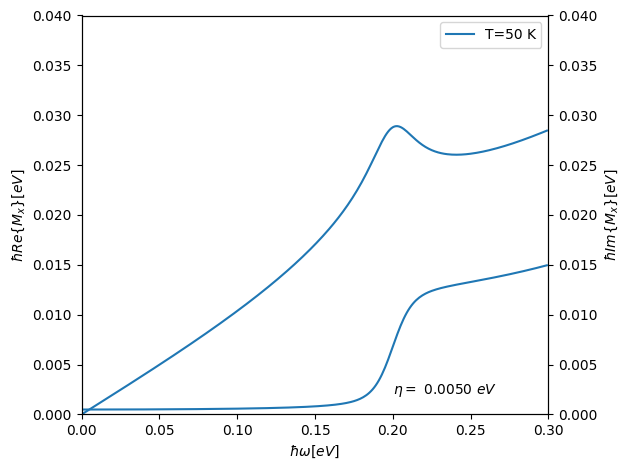

In [7]:
fig, *axs = setup_plot()
integrals = calculate_integral_points(mem_fn)
plot_real_and_imag_result(*axs, *integrals, T=T_0)
axs[0].legend(loc="best")
fig.tight_layout()

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_5372\708704223.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)


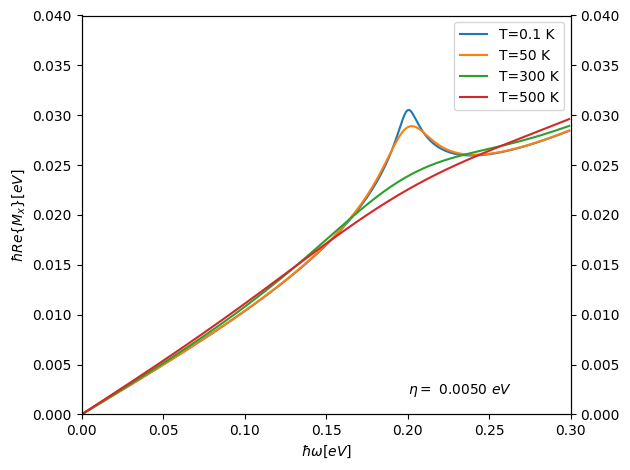

In [8]:
fig, *axs = setup_plot(imag=False)
for T in [0.1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn, T=T)
    plot_result(axs[0], integrals[0], T=T)
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
fig.tight_layout()

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_5372\208584364.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)


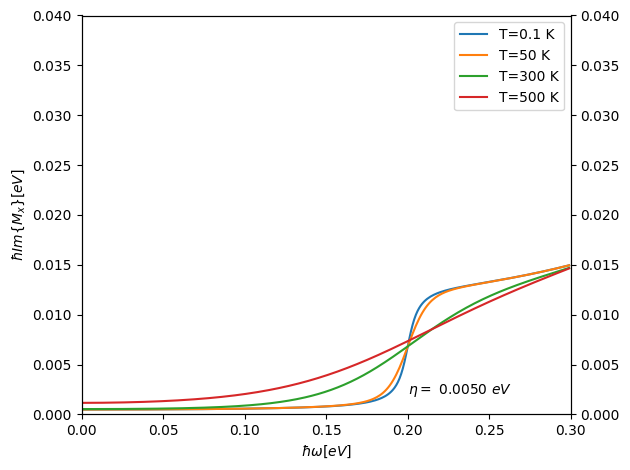

In [9]:
fig, *axs = setup_plot(real=False)
for T in [0.1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn, T=T)
    plot_result(axs[0], integrals[1], T=T)
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
fig.tight_layout()

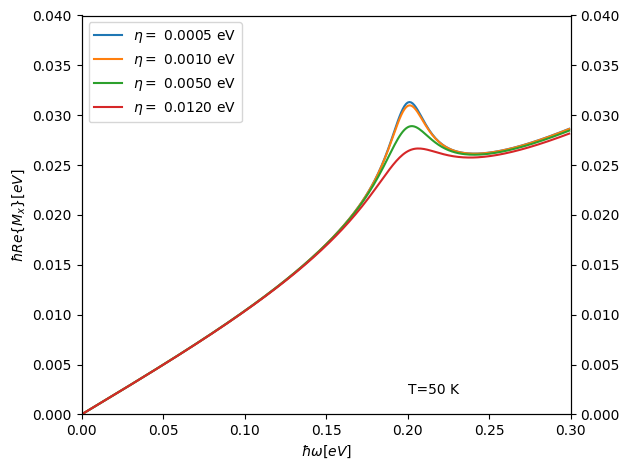

In [10]:
fig, *axs = setup_plot(imag=False)
for eta in [0.0005, 0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn, eta=eta)
    plot_result(axs[0], integrals[0], eta=eta)
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"T={T_0} K" , fontsize =10)
fig.tight_layout()

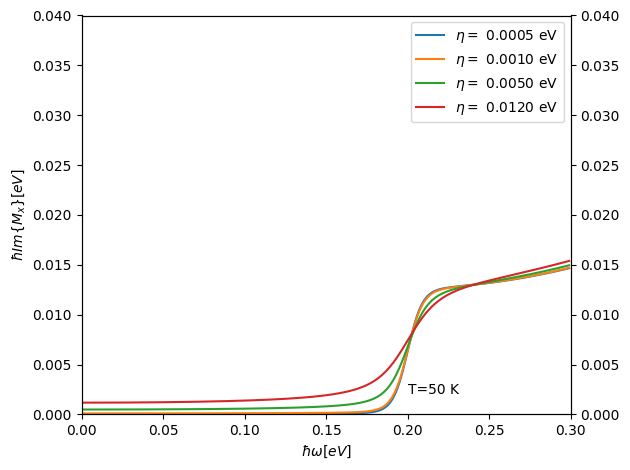

In [11]:
fig, *axs = setup_plot(real=False)
for eta in [0.0005, 0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn, eta=eta)
    plot_result(axs[0], integrals[1], eta=eta)
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"T={T_0} K" , fontsize =10)
fig.tight_layout()

Podintegralna funkcija za memorijsku funkciju

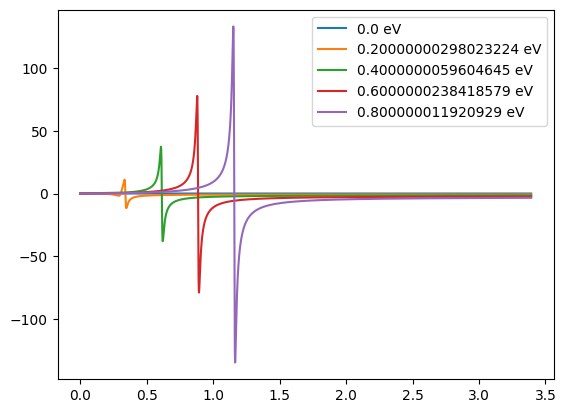

In [15]:
ws = torch.arange(0, 1, 0.2)
ks = torch.arange(0, Kf_*10, 0.001)
for w in ws:
    ss_sums = []
    for k in ks:
        ss = ss_sum_real(k, w, hbar_w_op, T_0, chemical_potential(T), eta_0).to("cpu")
        ss_sums.append(ss)
    plt.plot(ks.to("cpu"), ss_sums, label = f"{w} eV")
plt.legend()

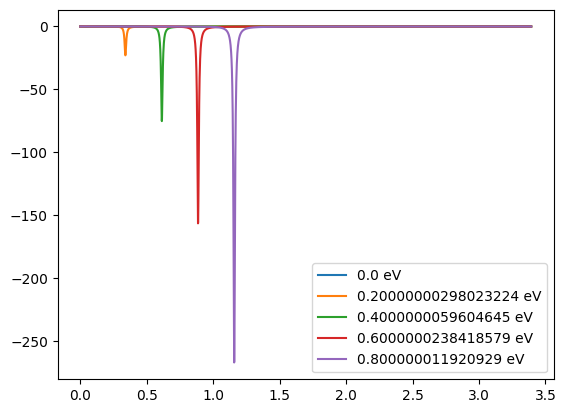

In [18]:
for w in ws:
    ss_sums = []
    for k in ks:
        ss = ss_sum_imag(k, w, hbar_w_op, T_0, chemical_potential(T), eta_0).to("cpu")
        ss_sums.append(ss)
    plt.plot(ks.to("cpu"), ss_sums, label = f"{w} eV")
plt.legend()

## Akustični fononi

In [78]:
def ss_sum_part(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta):
    def summand(s1, s2):
        abs_K = sqrt(K**2 + Kf_**2 - 2 * Kf_ * K * sin(theta) * cos(phi))
        factor = 1 - K * sin(theta) * cos(phi) * Ef / eps(K) / Kf_
        return (bose_einstein(hbar_w_ph * abs_K, T) + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)) / (hbar_w + s1 * Ef - s1 * eps(K) + s2 * hbar_w_ph * abs_K + eta * 1j) * abs_K * factor
    sum = 0
    for s1, s2 in itertools.product([-1,1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum * K**2 * sin(theta)

def ss_sum_real(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta).real

def ss_sum_imag(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta).imag

def mem_fn_ac(ss_sum_fn, hbar_w, hbar_w_ph, u, T, eta):
    integration_domain = torch.Tensor([[0, Kf_*6], [0, pi], [0, 2*pi]])
    tp=Trapezoid()
    def integrand(K):
        return ss_sum_fn(K[:,0], K[:,1], K[:,2], hbar_w, hbar_w_ph, T, u, eta)
    integral_k_theta_phi = tp.integrate(integrand, dim=3, N=10**7, integration_domain=integration_domain)
    return -G_ac2 * integral_k_theta_phi/ (2*pi)**3


**Memorijska funkcija**

c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchquad\integration\utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


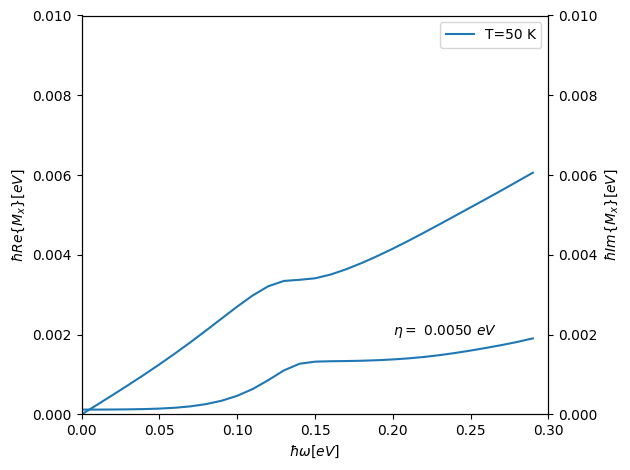

In [79]:
fig, *axs = setup_plot(y_lim=[0,0.01])
integrals = calculate_integral_points(mem_fn_ac, ws=torch.arange(0,0.3,0.01))
plot_real_and_imag_result(*axs, *integrals, T=T_0, ws=torch.arange(0,0.3,0.01))
axs[0].legend(loc="best")
fig.tight_layout()

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_5372\3619451414.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)


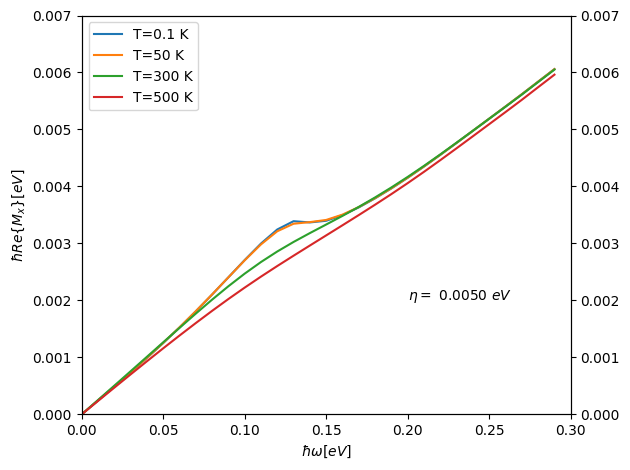

In [50]:
fig, *axs = setup_plot(imag=False, y_lim=[0,0.007])
for T in [0.1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn_ac, T=T, ws=torch.arange(0,0.3,0.01))
    plot_result(axs[0], integrals[0], T=T, ws=torch.arange(0,0.3,0.01))
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
fig.tight_layout()

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_5372\1178216151.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)


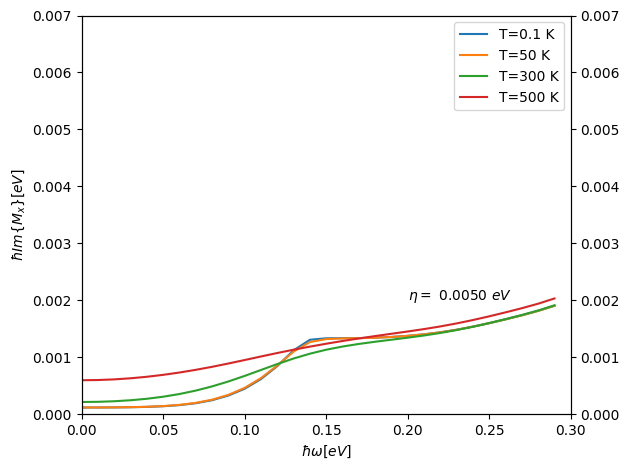

In [51]:
fig, *axs = setup_plot(real=False, y_lim=[0,0.007])
for T in [0.1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn_ac, T=T, ws=torch.arange(0,0.3,0.01))
    plot_result(axs[0], integrals[1], T=T, ws=torch.arange(0,0.3,0.01))
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
fig.tight_layout()

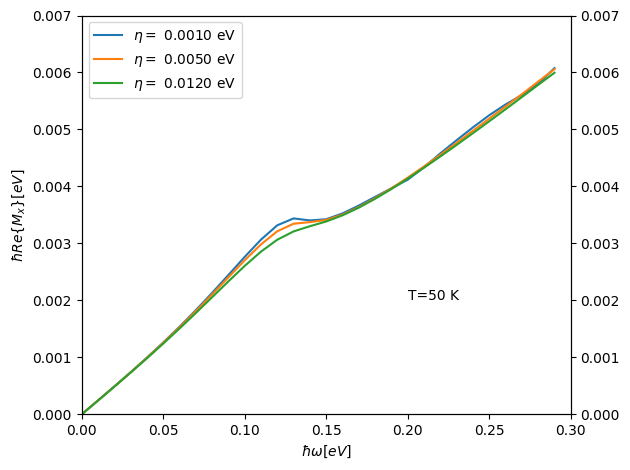

In [52]:
fig, *axs = setup_plot(imag=False, y_lim=[0,0.007])
for eta in [0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn_ac, eta=eta, ws=torch.arange(0,0.3,0.01))
    plot_result(axs[0], integrals[0], eta=eta, ws=torch.arange(0,0.3,0.01))
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"T={T_0} K" , fontsize =10)
fig.tight_layout()

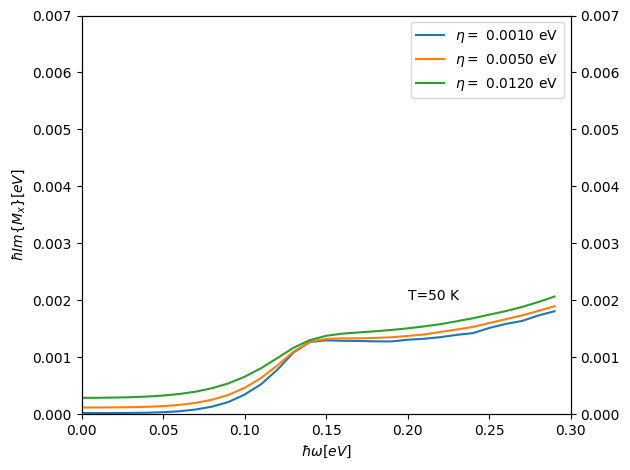

In [68]:
fig, *axs = setup_plot(real=False, y_lim=[0,0.007])
for eta in [0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn_ac, eta=eta, ws=torch.arange(0,0.3,0.01))
    plot_result(axs[0], integrals[1], eta=eta, ws=torch.arange(0,0.3,0.01))
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"T={T_0} K" , fontsize =10)
fig.tight_layout()